# <center> Train the LSTM network with word2vec embeddings </center>

This notebook is very similar to the first lstm training. This time we will train the lstm network on the training and validation data and predict its performance on the test data. My solution is again based on these two guidelines.
https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html


Okay now let's import all of the necessary modules:

In [1]:
import os
import gensim
import numpy as np
import pandas as pd
from IPython.display import display
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import log_loss, accuracy_score
from capstone_project import utility
from capstone_project.models import neural_nets

%matplotlib inline

Using TensorFlow backend.
/home/andre/anaconda3/envs/capstone_project/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Set important constants and load data:

In [2]:
MAX_SEQUENCE_LENGTH = 30 # Maximum length of input for lstm the (maximum number of tokens is 103) 
EMBEDDING_DIM = 300  # Length of the used word2vec/glove implementation
USE_RAW_TEXT = True  # Use raw text as input instead of tokens
USE_WORD2VEC = True  # Use word2vec embedding instead of glove embedding
VALIDATION_SPLIT = 0.1  # Size of the second validation set that is used during the training of the lstm

In [3]:
file_directory = "../output/data/"
prefix = "tokenized_"

train_data_1 = utility.load_pickle(file_directory, prefix+"train_data.pkl")
train_data_2 = utility.load_pickle(file_directory, prefix+"val_data.pkl")  # Validation data set used to compare different classification algorithms
test_data = utility.load_pickle(file_directory, prefix+"test_data.pkl")  # Validation data set used to compare different classification algorithms

joined_data = pd.concat([train_data_1, train_data_2]) 

labels = joined_data["is_duplicate"].values
test_labels = test_data["is_duplicate"].values

Make sure that the concatenate worked:

In [4]:
assert len(train_data_1) + len(train_data_2) == len(joined_data)
display(joined_data.head(1))

,id,qid1,qid2,question1,question2,is_duplicate,q1_tokens,q2_tokens
355802,355802,696825,696826,Which are the best songs of Enrique Iglesias?,Which is the best song of Enrique iglesias?,1,"[good, song, enrique, iglesias]","[good, song, enrique, iglesias]"


Prepare the tokenized question as input for keras:

In [5]:
# Decode again and join strings because keras tokenizer crashes when using unicode while spacy uses it
if USE_RAW_TEXT:
    q1 = joined_data["question1"].values
    q2 = joined_data["question2"].values
else:
    q1 = joined_data["q1_tokens"].apply(lambda x: unidecode(u" ".join(x))).values
    q2 = joined_data["q2_tokens"].apply(lambda x: unidecode(u" ".join(x))).values
    
all_questions = np.concatenate([q1, q2])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_questions)

word_index = tokenizer.word_index
number_words = len(word_index)+1  # Needed for embedding layer
print("Found {} unique tokens".format(len(word_index)))

q1_sequences = tokenizer.texts_to_sequences(q1)
q2_sequences = tokenizer.texts_to_sequences(q2)

q1_data = pad_sequences(q1_sequences, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(q2_sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 91208 unique tokens


Split second validation and training set for validation at every epoch. The dataset size is also doubled by switching the order of the questions. This is done in order to avoid symmetry issues.

In [6]:
# Credit: https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings
perm = np.random.permutation(len(q1_data))
idx_train = perm[:int(len(q1_data)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(q1_data)*(1-VALIDATION_SPLIT)):]

q12_train = np.concatenate((q1_data[idx_train], q2_data[idx_train]), axis=0)
q21_train = np.concatenate((q2_data[idx_train], q1_data[idx_train]), axis=0)
double_train_labels = np.concatenate((labels[idx_train], labels[idx_train]), axis=0)

q12_val_epochs = np.concatenate((q1_data[idx_val], q2_data[idx_val]), axis=0)
q21_val_epochs = np.concatenate((q2_data[idx_val], q1_data[idx_val]), axis=0)
double_val_epochs_labels = np.concatenate((labels[idx_val], labels[idx_val]), axis=0)

Prepare test set:

In [13]:
#create correct embeddings for validation data
if USE_RAW_TEXT:
    q1_test = test_data["question1"].values
    q2_test = test_data["question2"].values
else:
    q1_test = test_data["q1_tokens"].apply(lambda x: unidecode(u" ".join(x))).values
    q2_test = test_data["q2_tokens"].apply(lambda x: unidecode(u" ".join(x))).values
    
q1_test_sequences = tokenizer.texts_to_sequences(q1_test)
q2_test_sequences = tokenizer.texts_to_sequences(q2_test)

q1_test_data = pad_sequences(q1_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
q2_test_data = pad_sequences(q2_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

Load the pretrained vectorization model and create the embedding matrix:

In [8]:
if USE_WORD2VEC:
    word2vec_model = gensim.models.KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz",
                                                                     binary=True)
    
    embedding_matrix = neural_nets.create_embedding_matrix(vec_model=word2vec_model, embedding_dim=EMBEDDING_DIM, 
                                                           word_index=word_index, number_words=number_words)
else:
    # Credit: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
    embeddings_index = {}
    f = open('../data/glove.42B.300d.txt')
    
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Null word embeddings: 44664


Set the parameters of the lstm and create a keras model:

In [9]:
batch_size = 2048
nn_parameters = {"max_sequence_length": MAX_SEQUENCE_LENGTH,
                 "num_lstm": 230,
                 "dropout_lstm": 0.35,
                 "num_dense": 128,
                 "dropout_dense": 0.35}

stamp = "{}_{:.2f}_{}_{:.2f}".format(nn_parameters["num_lstm"], 
                                    nn_parameters["dropout_lstm"],
                                    nn_parameters["num_dense"],
                                    nn_parameters["dropout_dense"])

model = neural_nets.create_lstm(embedding_matrix=embedding_matrix, 
                                embedding_dim=EMBEDDING_DIM, 
                                number_words=number_words, 
                                **nn_parameters)

model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
model.summary()
print stamp

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 30, 300)       27362700    input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 230)           488520      embedding_1[0][0]       

Train the data and check the performance on the second validation set every epoch. with early stopping:

In [10]:
#Credit: https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
best_model_path = "../output/models/final_lstm_val_epochs_" + stamp + '.h5'
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit([q12_train, q21_train], double_train_labels,
                 validation_data=([q12_val_epochs, q21_val_epochs], double_val_epochs_labels), 
                 epochs=200, batch_size=batch_size, shuffle=True,
                 callbacks=[early_stopping, model_checkpoint])

Train on 655046 samples, validate on 72784 samples
Epoch 1/200
655046/655046 [==============================] - 245s - loss: 0.5794 - acc: 0.6975 - val_loss: 0.5524 - val_acc: 0.7263
Epoch 2/200
655046/655046 [==============================] - 242s - loss: 0.5082 - acc: 0.7440 - val_loss: 0.4753 - val_acc: 0.7767
Epoch 3/200
655046/655046 [==============================] - 242s - loss: 0.4747 - acc: 0.7658 - val_loss: 0.4483 - val_acc: 0.7864
Epoch 4/200
655046/655046 [==============================] - 242s - loss: 0.4531 - acc: 0.7790 - val_loss: 0.4278 - val_acc: 0.7991
Epoch 5/200
655046/655046 [==============================] - 243s - loss: 0.4376 - acc: 0.7887 - val_loss: 0.4180 - val_acc: 0.8021
Epoch 6/200
655046/655046 [==============================] - 243s - loss: 0.4260 - acc: 0.7956 - val_loss: 0.4054 - val_acc: 0.8089
Epoch 7/200
655046/655046 [==============================] - 242s - loss: 0.4163 - acc: 0.8016 - val_loss: 0.3933 - val_acc: 0.8164
Epoch 8/200
655046/655046

Display training histoty of LSTM:

['acc', 'loss', 'val_acc', 'val_loss']


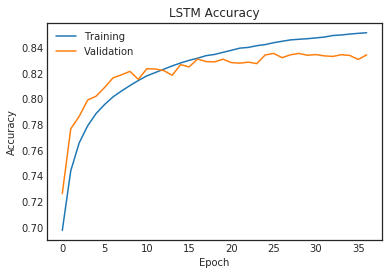

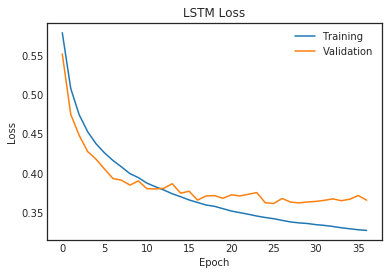

In [11]:
# Credit: http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

# list all data in history
print(hist.history.keys())

# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig("../output/figures/final_lstm_hist_acc_plot.png")
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig("../output/figures/final_lstm_hist_loss_plot.png")
plt.show()

Load the trained model and calculate logloss and accuarcy on the validation set:

In [16]:
model.load_weights(best_model_path)
predictions = model.predict([q1_test_data, q2_test_data], batch_size=batch_size, verbose=1)
predictions += model.predict([q2_test_data, q1_test_data], batch_size=batch_size, verbose=1)
predictions /= 2

# Quick fix: Log loss returns nan if any of the predictions are very confident(==1.)
predictions[predictions == 1] = 0.9999999
utility.save_pickle(predictions, file_directory, "final_lstm_preds_on_val.pkl")

loss = log_loss(test_labels, predictions)
acc = accuracy_score(test_labels, np.rint(predictions))

print "Test scores of Lstm model\n LogLoss: {:.4f}\n Accuracy: {:.2f} ".format(loss, acc)

40436/40436 [==============================] - 5s     
Test scores of Lstm model
 LogLoss: 0.3670
 Accuracy: 0.83 


Create roc plot and save it:

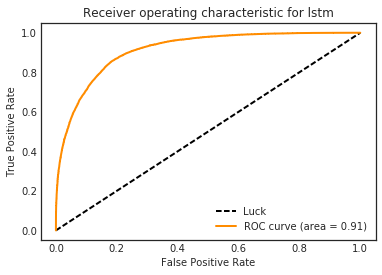

In [17]:
plt = utility.create_roc_plot(test_labels, predictions, "lstm")
plt.savefig("../output/figures/final_lstm_roc_plot.png")
plt.show()